In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;

from scipy.stats.mstats import normaltest
import scipy.stats as sps

# sys.path.insert(0,os.path.join("..", "..", "dependencies"))
import pyemu
import flopy
assert "dependencies" in flopy.__file__
assert "dependencies" in pyemu.__file__
sys.path.insert(0,"..")
import herebedragons as hbd
import geostat_helpers as gh


plt.rcParams['font.size'] = 10
pyemu.plot_utils.font =10




# Geostatistics 

This notebook is a very high-level introduction to geostatisics. Some definitions from Geoff Bohling https://www.coursehero.com/file/12867665/Variograms/

> “Geostatistics: study of phenomena that vary in space and/or time.” 
(Deutsch, 2002)

> “Geostatistics can be regarded as a collection of numerical techniques that deal with the characterization of spatial attributes, employing primarily random models in a manner similar to the way in which time series analysis characterizes temporal data.” 
(Olea, 1999)

> “Geostatistics offers a way of describing the spatial continuity of natural phenomena and provides adaptations of classical regression techniques to take advantage of this continuity.”  
(Isaaks and Srivastava, 1989)

> Geostatistics deals with spatially _autocorrelated_ data.

> "Autocorrelation: correlation between elements of a series and others from the same series separated from them by a given interval."(Oxford American Dictionary)

# Main Concepts

1. Variogram modeling -- a way to characterize spatial correlation
2. Kriging -- a best linear unbiased estimate (BLUE) for interpolation with minimum variance. There are several flavors - we will focus on Ordinary Kriging
3. Stochastic Simulation -- http://petrowiki.org/Geostatistical_conditional_simulation
4. Beyond this multi-Gaussian approach focused on the relationships among pairs of points, there is _multiple point geostatistics_ as well using training images and more complex shapes

These concepts each build on each other. We will briefly touch on the first two.

### Generate a Field
Let's cook up a quick random field and explore the spatial structure. 

In [2]:
X,Y,Z,v,gs,sample_df = gh.data_cooker()

Initializing a variogram model
Making the domain
Initializing covariance model
Drawing from the Geostatistical Model
SpecSim.initialize() summary: full_delx X full_dely: 2162 X 2162


### Visualize the Field
Pretend (key word!) that this is a hydraulic conductivity field. What do you think? Any _autocorrelation_ here? 
Note how values spread _continuously_. Points which are close together have similar values. They are not _entirely_ random.

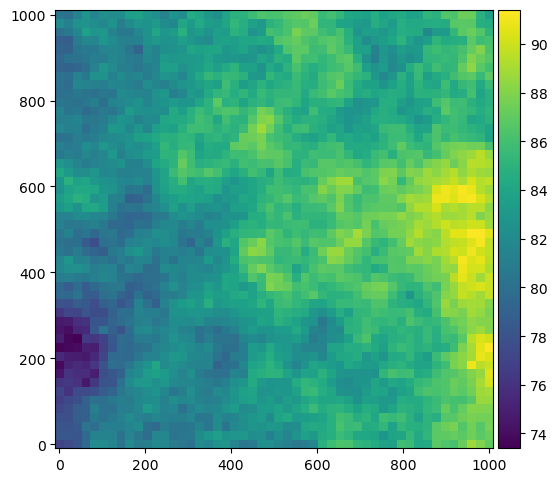

In [3]:
gh.grid_plot(X,Y,Z);

### Link to the Real-World

In practice, we would typically only know the values at a few points (and probably not perfectly). (Think pumping tests or other point-sample site characterisation methods.) So how do we go from these "few" samples to a continuous parameter field?

>note: the default number of samples we use here is 50.

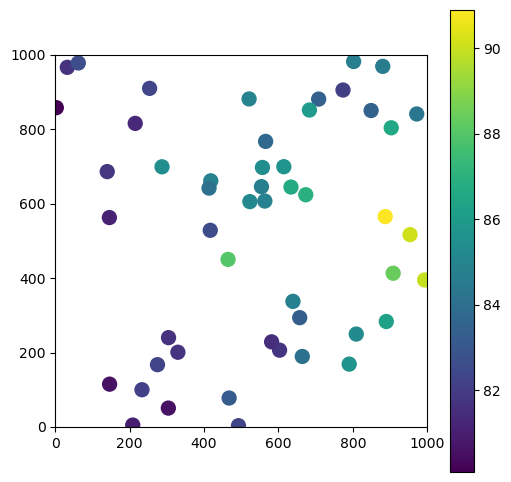

In [4]:
gh.field_scatterplot(sample_df.x,sample_df.y,sample_df.z);

## Main Assumptions:
   1. The values are second order stationary (the mean and variance are relatively constant) 
   2. The values are multi-Gaussian (e.g. normally distributed)

If we inspect our generated data, we see that it is normally distributed, so that's good. (_side note: of course it is, we generated it using geostatistics..so we are cheating here..._)

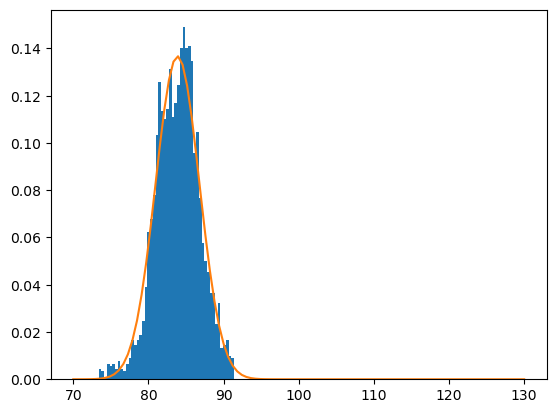

In [5]:
plt.hist(Z.ravel(), bins=50, density=True)
x=np.linspace(70,130,100)
plt.plot(x,sps.norm.pdf(x, np.mean(Z),np.std(Z)));

What about our sample?

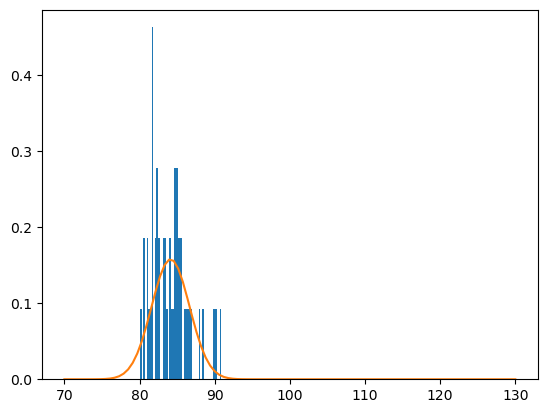

In [6]:
plt.hist(sample_df.z, bins=50, density=True)
x=np.linspace(70,130,100)
plt.plot(x,sps.norm.pdf(x, np.mean(sample_df.z),np.std(sample_df.z)))

Purity is commendable, but in practice we are going to violate some of these assumptions for sure. 

### Variograms
At the heart of geostatistics is some kind of model expressing the variability of properties in a field. This is a "variogram" and we can explore it based on the following empirical formula:

 $$\hat{\gamma}\left(h\right)=\frac{1}{2\left(h\right)}\left(z\left(x_1\right)-z\left(x_2\right)\right)^2$$
 
where $x_1$ and $x_2$ are the locations of two $z$ data points separated by distance $h$.



If we plot these up we get something called a cloud plot showing $\hat\gamma$ for all pairs in the dataset

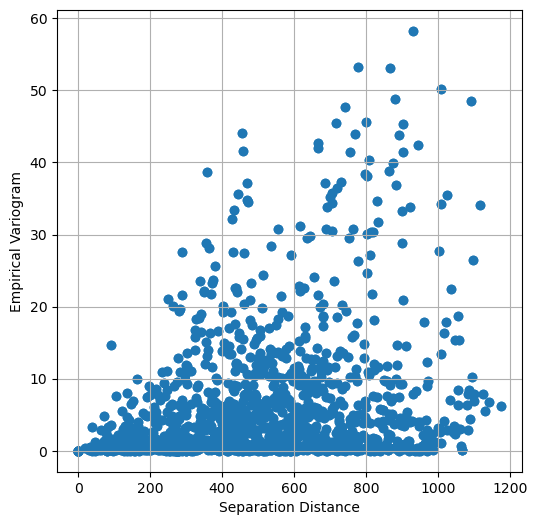

In [7]:
h,gam,ax=gh.plot_empirical_variogram(sample_df.x,sample_df.y,sample_df.z,0)

This is pretty messy, so typically it is evaluated in bins, and usually only over half the total possible distance

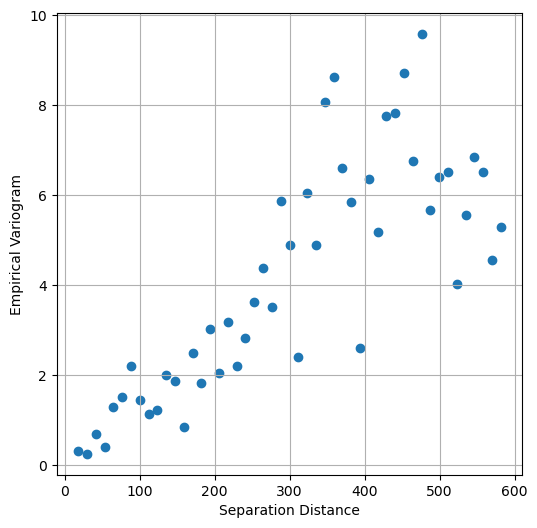

In [8]:
h,gam,ax=gh.plot_empirical_variogram(sample_df.x,sample_df.y,sample_df.z,50)

Also note that this was assuming perfect observations. What if there was ~10% noise?

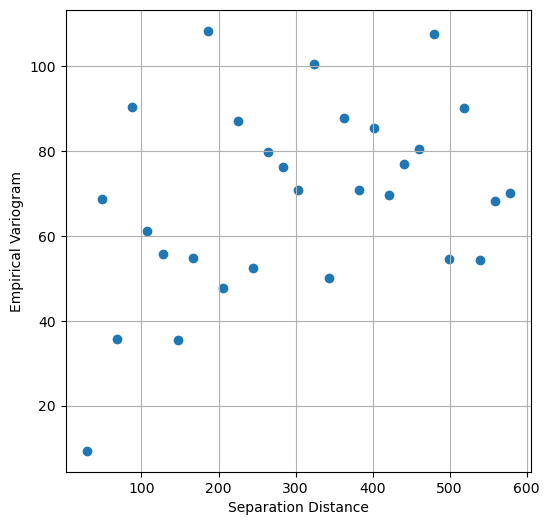

In [9]:
h,gam,ax=gh.plot_empirical_variogram(sample_df.x,sample_df.y,sample_df.z_noisy,30)

Geostatistics is making the assumption that you can model the variability of this field using a variogram. The variogram is closely related to covariance. We take advantage of a few assumptions to come up with a few functional forms that should characterize this behavior.

## Variograms in `pyemu`
`pyemu` supports three variogram models. (As do most of the utilities in the PEST-suite of software.)
This follows the _GSLIB_ terminology:
 1. *Spherical*  
 $\gamma\left(h\right)=c\times\left[1.5\frac{h}{a}-0.5\frac{h}{a}^3\right]$ if $h<a$
 $\gamma\left(h\right)=c$ if $h \ge a$  
  
 2. *Exponential*  
 $\gamma\left(h\right)=c\times\left[1-\exp\left(-\frac{h}{a}\right)\right]$  
  
 3. *Gaussian*  
 $\gamma\left(h\right)=c\times\left[1-\exp\left(-\frac{h^2}{a^2}\right)\right]$  
  
 $h$ is the separation distance, and $a$ is the range. `contribution` is the variogram value at which the variogram levels off. Also called the `sill`, this value is the maximum variability between points.
 The sill is reached at about $a$ for the *Spherical* model, $2a$ for the *Gaussian*, and $3a$ for the *Exponential*

### What do these look like?

For a consistent set of parameters:
 > a=500, c=10
 
 We can use `pyemu` to setup a geostatistical model

In [10]:
a=500
c=10

Set up a variogram object and, from that, build a geostatistical structure

### _Spherical_

In [11]:
v = pyemu.geostats.SphVario(contribution=c, a=a)
gs = pyemu.geostats.GeoStruct(variograms=v)

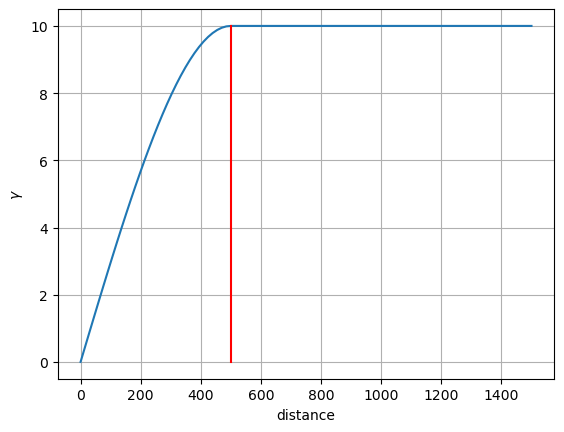

In [12]:
gs.plot()
plt.plot([v.a,v.a],[0,v.contribution],'r')
plt.grid()

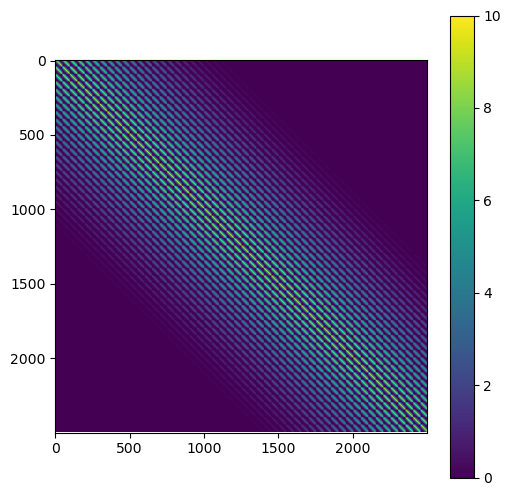

In [13]:
Q= gs.covariance_matrix(X.ravel(), Y.ravel(), names=[str(i) for i in range(len(Y.ravel()))])
plt.figure(figsize=(6,6))
plt.imshow(Q.x)
plt.colorbar();

### _Exponential_

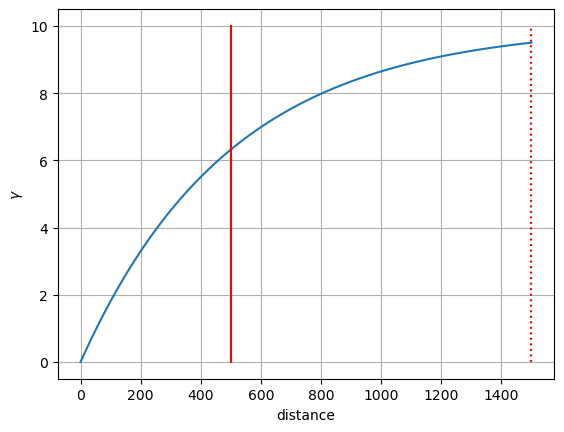

In [14]:
v = pyemu.geostats.ExpVario(contribution=c, a=a)
gs = pyemu.geostats.GeoStruct(variograms=v)
gs.plot()
plt.plot([v.a,v.a],[0,v.contribution],'r')
plt.plot([3*v.a,3*v.a],[0,v.contribution],'r:')
plt.grid();

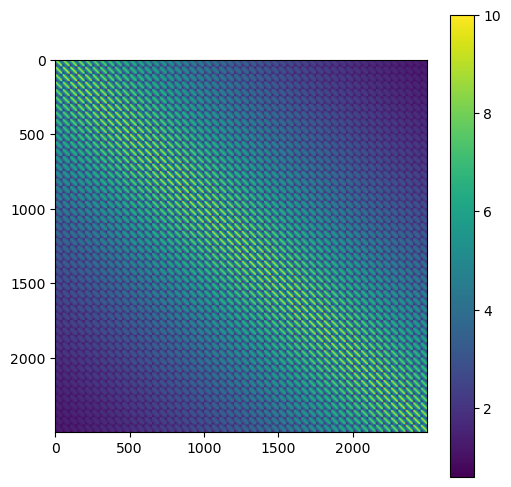

In [15]:
Q= gs.covariance_matrix(X.ravel(), Y.ravel(), names=[str(i) for i in range(len(Y.ravel()))])
plt.figure(figsize=(6,6))
plt.imshow(Q.x)
plt.colorbar();

### _Gaussian_

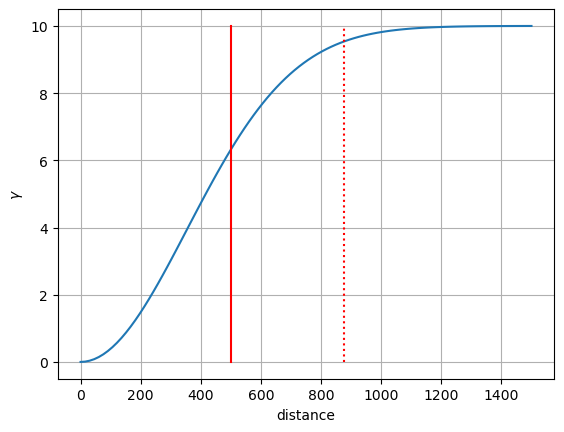

In [16]:
v = pyemu.geostats.GauVario(contribution=c, a=a)
gs = pyemu.geostats.GeoStruct(variograms=v)
gs.plot()
plt.plot([v.a,v.a],[0,v.contribution],'r')
plt.plot([7/4*v.a,7/4*v.a],[0,v.contribution],'r:')
plt.grid();

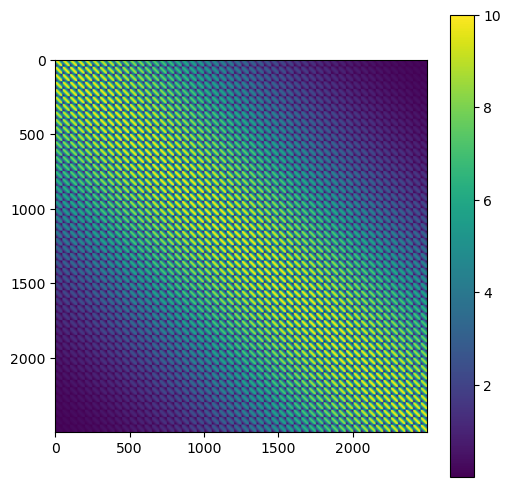

In [17]:
Q= gs.covariance_matrix(X.ravel(), Y.ravel(), names=[str(i) for i in range(len(Y.ravel()))])
plt.figure(figsize=(6,6))
plt.imshow(Q.x)
plt.colorbar();

## Interpolating from Sparse Data
So how do we go from a sample of measurments (i.e. our 50 points, sampled from the field at the start of the notebook) and generate a continuous field? If we fit an appropriate model ($\gamma$) to the empirical variogram ($\hat\gamma$), we can use that structure for interpolation from sparse data.

Experiment below with changing the `new_a` and `new_c` variables and/or the variogram type.

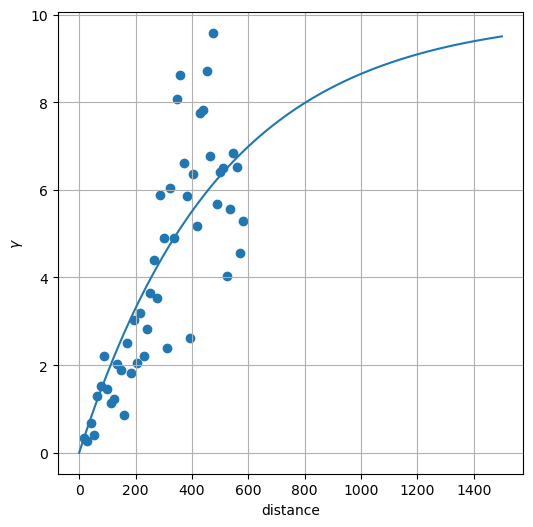

In [18]:
h,gam,ax=gh.plot_empirical_variogram(sample_df.x,sample_df.y,sample_df.z,50)
new_c=10
new_a=500.0

v_fit = pyemu.geostats.ExpVario(contribution=new_c,a=new_a)
gs_fit = pyemu.geostats.GeoStruct(variograms=v_fit)
gs_fit.plot(ax=ax);

In [19]:
Q = gs_fit.covariance_matrix(X.ravel(), Y.ravel(), names=[str(i) for i in range(len(Y.ravel()))])

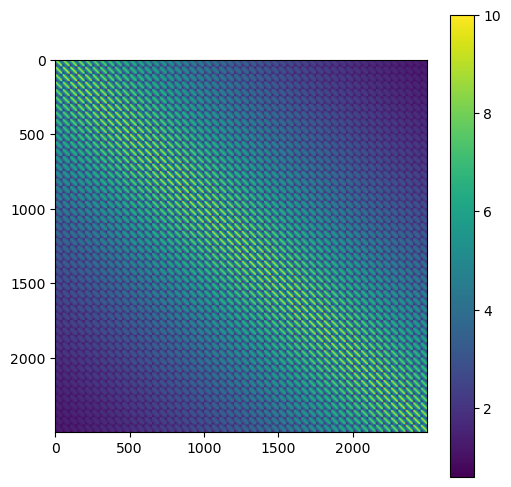

In [20]:
plt.figure(figsize=(6,6))
plt.imshow(Q.x)
plt.colorbar();

Now we can perform Kriging to interpolate using this variogram and our "sample data". First make an Ordinary Kriging object:

In [21]:
k = pyemu.geostats.OrdinaryKrige(gs_fit,sample_df)

In [22]:
sample_df.head()

,x,y,z,z_noisy,name
name,,,,,
p0,287.116655,699.455696,85.372835,83.771018,p0
p1,253.732612,910.336327,82.353507,96.801400,p1
p2,274.886538,167.553939,82.260247,82.146898,p2
p3,32.513697,966.814451,81.683278,79.377728,p3
p4,565.624540,767.730971,83.725429,85.923798,p4


Next we need to calculate factors (we only do this once - takes a few seconds)

In [23]:
kfactors = k.calc_factors(X.ravel(),Y.ravel())

starting interp point loop for 2500 points
took 2.504041 seconds


It's easiest to think of these factors as weights on surrounding point to calculate a weighted average of the surrounding values. The weight is a function of the distance - points father away have smaller weights.

In [24]:
kfactors.head()

,x,y,idist,inames,ifacts,err_var
0,1.000000,1.0,"[184.7051991534765, 207.40971945627004, 386.50730584099625, 491.60458345801544, 580.295266631326...","[p38, p20, p40, p37, p36, p33, p10, p35, p18, p0, p43]","[0.4327770142438521, 0.3417529484244284, 0.004059230296319405, 0.04778912246916972, 0.0501610806...",2.767218
1,21.387755,1.0,"[169.14795023838278, 187.0266048520901, 370.70802497724264, 471.21711009351276, 575.554567272516...","[p38, p20, p40, p37, p36, p33, p10, p35, p18, p0, p43]","[0.4360428757975899, 0.36167431286832813, 0.00206045452338225, 0.04483723075668419, 0.0440368258...",2.574679
2,41.775510,1.0,"[154.71706002108814, 166.64462558472334, 450.82966221072473, 571.5022698624969, 650.332363132082...","[p38, p20, p37, p36, p33, p35, p18, p10, p0, p43]","[0.43557284599104173, 0.38571238564073923, 0.041766258070064954, 0.03765454657692188, 0.02281495...",2.374874
3,62.163265,1.0,"[141.7569376414895, 146.264256283779, 430.4422434303959, 568.1531044744195, 630.8486277459325, 6...","[p38, p20, p37, p36, p33, p35, p18, p10, p43, p0]","[0.42882967662347815, 0.4144281090265214, 0.038478280336504606, 0.03109342162082102, 0.020085860...",2.169980
4,82.551020,1.0,"[125.8862788886181, 130.70581927985793, 410.0548580933408, 565.5195636810955, 645.0133254748288,...","[p20, p38, p37, p36, p35, p18, p10, p43, p30]","[0.45235162664036943, 0.41636993457552096, 0.03176622888874155, 0.02508944553343006, 0.001419505...",2.009520


Now interpolate from our sampled points to a grid:

In [25]:
Z_interp = gh.geostat_interpolate(X,Y,k.interp_data, sample_df)

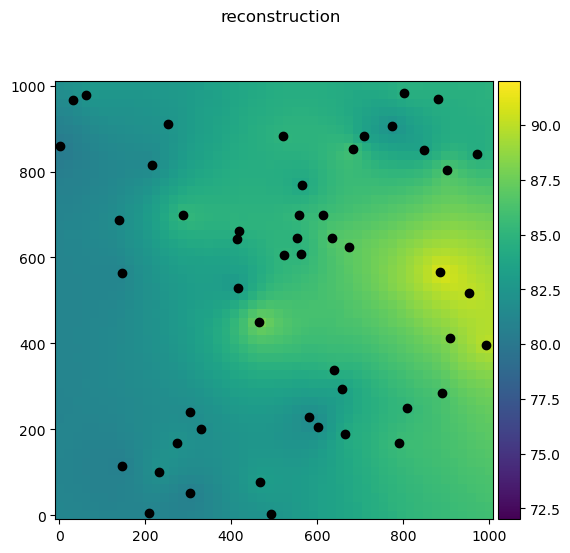

In [26]:
ax=gh.grid_plot(X,Y,Z_interp, title='reconstruction', vlims=[72,92])
ax.plot(sample_df.x,sample_df.y, 'ko');

<Axes: >

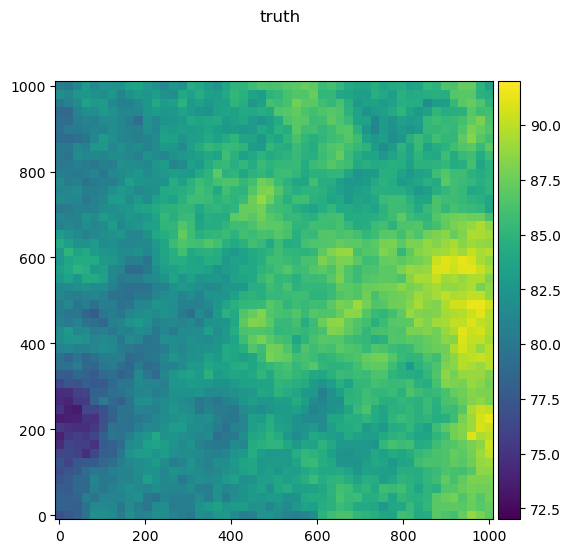

In [27]:
gh.grid_plot(X,Y,Z,title='truth', vlims=[72,92])

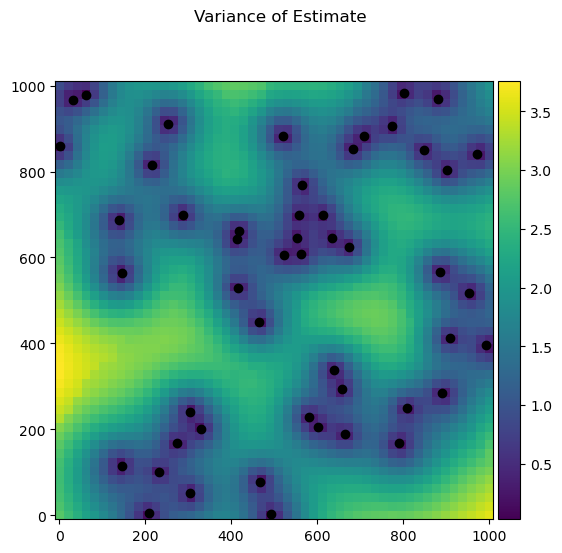

In [28]:
ax=gh.grid_plot(X,Y,kfactors.err_var.values.reshape(X.shape), title='Variance of Estimate')
ax.plot(sample_df.x,sample_df.y, 'ko');

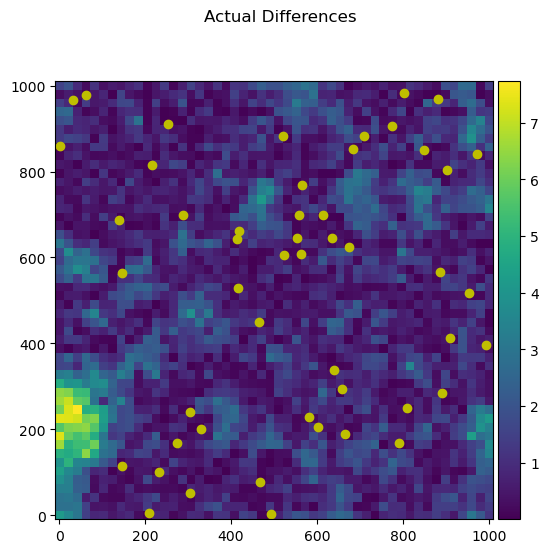

In [29]:
ax=gh.grid_plot(X,Y,np.abs(Z-Z_interp), title='Actual Differences')
ax.plot(sample_df.x,sample_df.y, 'yo');

## What if our data were noisy?

Try and get a good fit by adjusting the `new_c` and `new_a` values:

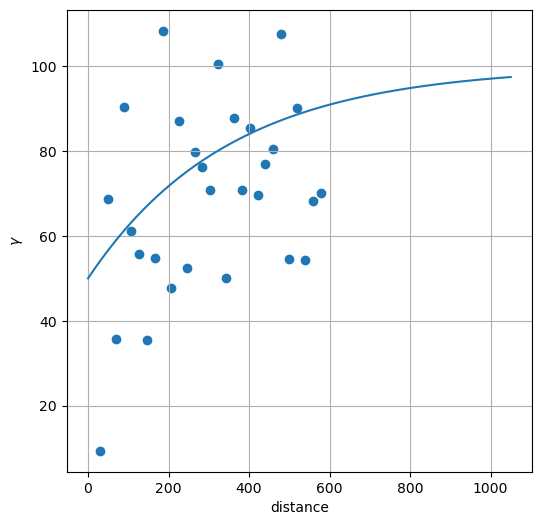

In [30]:
h,gam,ax=gh.plot_empirical_variogram(sample_df.x,sample_df.y,sample_df.z_noisy,30)
new_c=50.0
new_a=350.0

# select which kind of variogram here because in reality we don't know, right?
v_fit = pyemu.geostats.ExpVario(contribution=new_c,a=new_a)
gs_fit = pyemu.geostats.GeoStruct(variograms=v_fit, nugget=50)
gs_fit.plot(ax=ax);

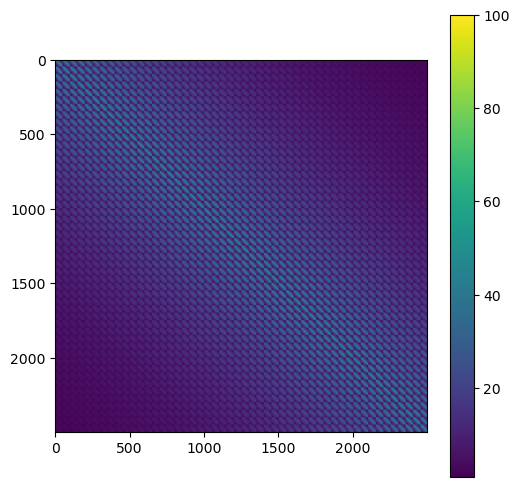

In [31]:
Q = gs_fit.covariance_matrix(X.ravel(), Y.ravel(), names=[str(i) for i in range(len(Y.ravel()))])
plt.figure(figsize=(6,6))
plt.imshow(Q.x)
plt.colorbar();

Again make the Kriging Object and the factors and interpolate

In [32]:
k = pyemu.geostats.OrdinaryKrige(gs_fit,sample_df)
kfactors = k.calc_factors(X.ravel(),Y.ravel())
Z_interp = gh.geostat_interpolate(X,Y,k.interp_data, sample_df)

starting interp point loop for 2500 points
took 2.457763 seconds


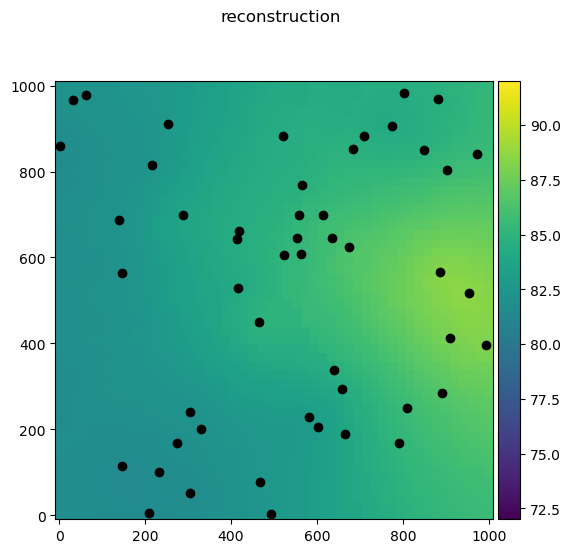

In [33]:
ax=gh.grid_plot(X,Y,Z_interp, vlims=[72,92], title='reconstruction')
ax.plot(sample_df.x,sample_df.y, 'ko')

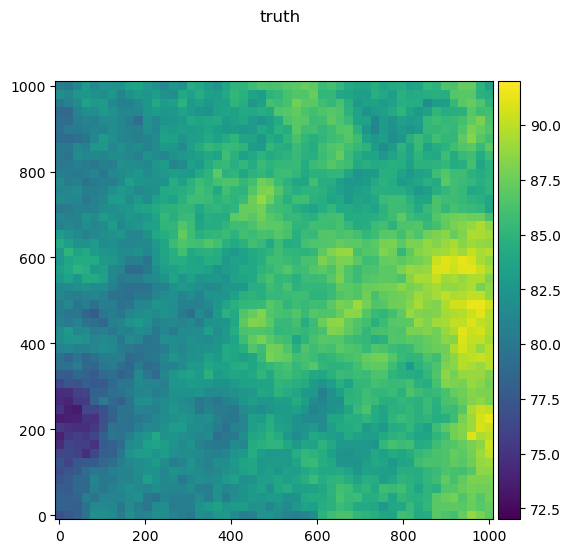

In [34]:
gh.grid_plot(X,Y,Z, vlims=[72,92],title='truth');

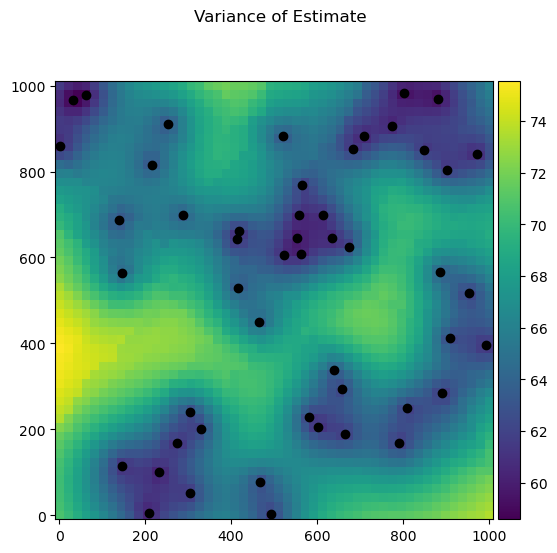

In [35]:
ax=gh.grid_plot(X,Y,kfactors.err_var.values.reshape(X.shape), title='Variance of Estimate')
ax.plot(sample_df.x,sample_df.y, 'ko');

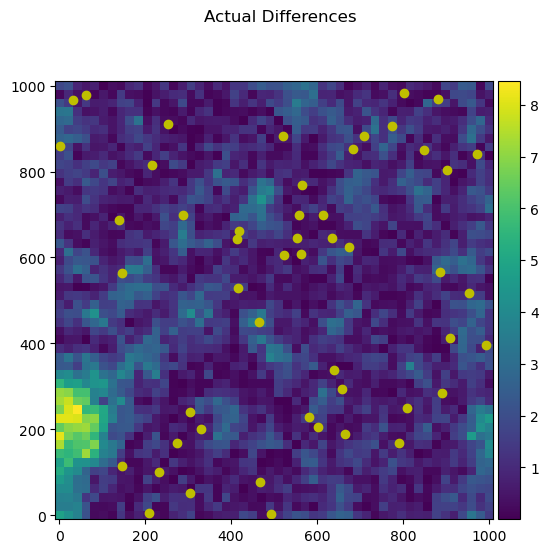

In [36]:
ax=gh.grid_plot(X,Y,np.abs(Z-Z_interp), title='Actual Differences')
ax.plot(sample_df.x,sample_df.y, 'yo')

### Spectral simulation

Because pyemu is pure python (and because the developers are lazy), it only implements spectral simulation for grid-scale field generation.  For regular grids without anisotropy and without conditioning data ("known" property values), it is identical to sequential gaussian simulation.

Each of the plots below illustrate the effect of different values of `a`. Experiment with changing `a`,  `contribution`, etc to get a feel for how they affect spatial patterns.

SpecSim.initialize() summary: full_delx X full_dely: 116 X 116


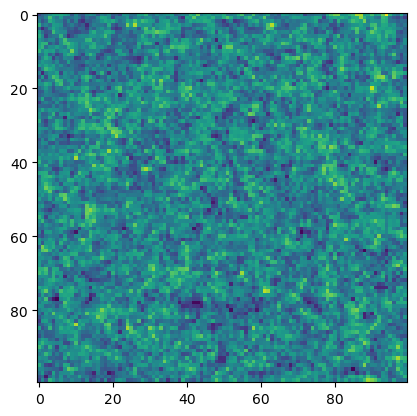

In [37]:
ev = pyemu.geostats.ExpVario(1.0,1, )
gs = pyemu.geostats.GeoStruct(variograms=ev)
ss = pyemu.geostats.SpecSim2d(np.ones(100),np.ones(100),gs)
plt.imshow(ss.draw_arrays()[0]);

SpecSim.initialize() summary: full_delx X full_dely: 132 X 132


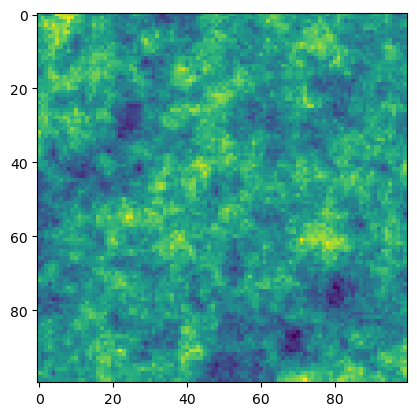

In [38]:
ev = pyemu.geostats.ExpVario(1.0,5)
gs = pyemu.geostats.GeoStruct(variograms=ev)
ss = pyemu.geostats.SpecSim2d(np.ones(100),np.ones(100),gs)
plt.imshow(ss.draw_arrays()[0]);

SpecSim.initialize() summary: full_delx X full_dely: 3108 X 3108


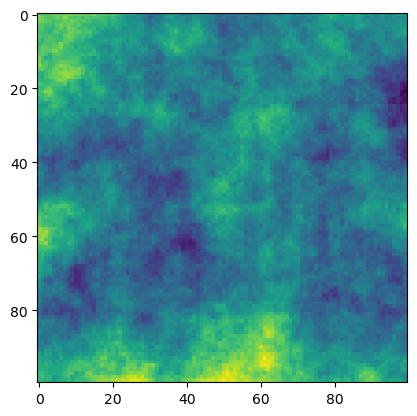

In [39]:
ev = pyemu.geostats.ExpVario(1.0,500)
gs = pyemu.geostats.GeoStruct(variograms=ev)
ss = pyemu.geostats.SpecSim2d(np.ones(100),np.ones(100),gs)
plt.imshow(ss.draw_arrays()[0]);

# Further resources and information
1. These concepts are used for pilot point interpolation in PEST:
    - In the GW utilities in PEST (https://pesthomepage.org/groundwater-utilities) 
    - The main tools are also available in `pyemu` -- we'll use that in the class
2. The Stanford Geostatistical Modeling Software (SGeMS: http://sgems.sourceforge.net/) is a nice GUI for geostatistical modeling, but it's not being maintained anymore.
3. Python libraries for geostistics:
    - [`gstools`](https://github.com/GeoStat-Framework/GSTools) Standalone Python toolset
    - [`pysgems`](https://github.com/robinthibaut/pysgems) uses SGEMS within Python 
    - [`Scikit-GStat`](https://github.com/mmaelicke/scikit-gstat). A tutorial can be found [here](https://guillaumeattard.com/geostatistics-applied-to-hydrogeology-with-scikit-gstat/)
4. `R` has a package: http://rgeostats.free.fr/